In [1]:
pwd

'P:\\Projects\\dalx\\notebooks'

In [2]:
cd ..

P:\Projects\dalx


In [3]:
import pandas as pd
import numpy as np
from src.utils import read_yaml, load_semeval15_laptop, search_keyword
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import altair as alt
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [4]:
dalx_bin = pd.read_csv('data/output/lexicon_table_dalx_07_thres0.7_C10.csv', index_col='WORD')
dalx_ter = pd.read_csv('data/output/lexicon_table_dalx_17_thres0.7_C10.csv', index_col='WORD')
gold = pd.read_csv('data/output/lexicon_table_dalx_15_gold_v2.csv', index_col='WORD')
general = pd.read_csv('data/processed/lexicon_table_v2.csv', index_col='WORD')

In [5]:
lx = general.mean(axis=1).to_frame('GENERIC')
lx.head()

,GENERIC
WORD,
$:,-0.375
%),-0.100
%-),-0.375
&-:,-0.100
&:,-0.175


In [6]:
lx['GOLD'] = gold['ANNOTATION']

In [7]:
lx.head()

,GENERIC,GOLD
WORD,,
$:,-0.375,NaN
%),-0.100,NaN
%-),-0.375,NaN
&-:,-0.100,NaN
&:,-0.175,NaN


In [8]:
lx['DALX_bin'] = dalx_bin[['MPQA', 'OPENER', 'OL', 'VADER']].mean(axis=1)

In [9]:
lx.head()

,GENERIC,GOLD,DALX_bin
WORD,,,
$:,-0.375,NaN,-0.375
%),-0.100,NaN,-0.100
%-),-0.375,NaN,-0.375
&-:,-0.100,NaN,-0.100
&:,-0.175,NaN,-0.175


In [10]:
lx['DALX_ter'] = dalx_ter[['MPQA', 'OPENER', 'OL', 'VADER']].mean(axis=1)

In [11]:
lx.dropna().shape

(839, 4)

In [12]:
U = lx.dropna()
_U = U.copy()

In [13]:
U.head()

,GENERIC,GOLD,DALX_bin,DALX_ter
WORD,,,,
ability,0.775,0.0,1.0,0.0
able,1.000,0.0,1.0,1.0
above,1.000,1.0,1.0,0.0
abrupt,-1.000,-1.0,-1.0,-1.0
absolute,0.000,0.0,1.0,0.0


In [14]:
def pol_to_cls(p):
    if p > 0:
        return '+1'
    elif p < 0:
        return '-1'
    else:
        return '00'

In [15]:
for c in U.columns:
    U[c] = U.loc[:, c].copy().apply(pol_to_cls)

p:\anaconda3\envs\atlx\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
U.head()

,GENERIC,GOLD,DALX_bin,DALX_ter
WORD,,,,
ability,+1,00,+1,00
able,+1,00,+1,+1
above,+1,+1,+1,00
abrupt,-1,-1,-1,-1
absolute,00,00,+1,00


In [17]:
def lx_acc(df, target_col, binary=False, gold_col='GOLD'):
    if binary:
        idx = df.loc[df[gold_col] != '00'].index
    else:
        idx = df.index
    labels = df.loc[idx, gold_col]
    predictions = df.loc[idx, target_col]
    assert len(labels) == len(predictions)
    acc = (predictions == labels).sum() / len(labels)
    
    if not binary:
        f1 = f1_score(labels, predictions, average='macro')
    else:
        labels = labels.astype(float).replace(-1, 0)
        predictions = predictions.astype(float).replace(-1, 0)
        f1 = f1_score(labels, predictions, average='binary')
    return acc, f1

In [18]:
lx_acc(U, 'GOLD', binary=False)

(1.0, 1.0)

In [19]:
lx_acc(U, 'GENERIC', binary=False)

(0.7699642431466031, 0.7440970112808357)

In [20]:
lx_acc(U, 'DALX_bin', binary=False)

(0.6460071513706794, 0.578881627427883)

In [21]:
lx_acc(U, 'DALX_ter', binary=False)

(0.7544696066746126, 0.7549305421777008)

In [22]:
lx_acc(U, 'GOLD', binary=True)

(1.0, 1.0)

In [23]:
lx_acc(U, 'GENERIC', binary=True)

(0.9658273381294964, 0.9664902998236331)

In [24]:
lx_acc(U, 'DALX_bin', binary=True)

(0.8992805755395683, 0.8985507246376812)

In [25]:
lx_acc(U, 'DALX_ter', binary=True)

(0.802158273381295, 0.8786127167630058)

# Plotting lexicon distribution

In [26]:
_U.head()

,GENERIC,GOLD,DALX_bin,DALX_ter
WORD,,,,
ability,0.775,0.0,1.0,0.0
able,1.000,0.0,1.0,1.0
above,1.000,1.0,1.0,0.0
abrupt,-1.000,-1.0,-1.0,-1.0
absolute,0.000,0.0,1.0,0.0


Text(0, 0.5, 'Counts')

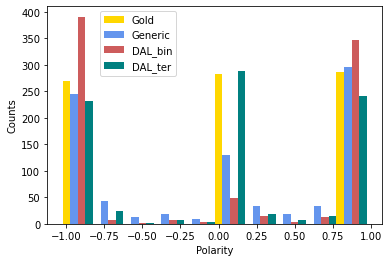

In [28]:
fig, ax = plt.subplots(figsize=None)


a_heights, a_bins = np.histogram(_U['GOLD'])
b_heights, b_bins = np.histogram(_U['GENERIC'], bins=a_bins)
c_heights, c_bins = np.histogram(_U['DALX_bin'], bins=a_bins)
d_heights, d_bins = np.histogram(_U['DALX_ter'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/4

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='gold')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='cornflowerblue')
ax.bar(c_bins[:-1]+width*2, c_heights, width=width, facecolor='indianred')
ax.bar(d_bins[:-1]+width*3, d_heights, width=width, facecolor='teal')

ax.figure.legend(['Gold', 'Generic', 'DAL_bin', 'DAL_ter'], bbox_to_anchor=(0.4,1),loc=1, bbox_transform=ax.transAxes)
ax.set_xlabel('Polarity')
ax.set_ylabel('Counts')

In [34]:
a_heights

array([245,  43,  13,  18,   9, 130,  34,  18,  33, 296], dtype=int64)

In [35]:
a_bins

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [38]:
_U.head()

,GENERIC,GOLD,DALX_bin,DALX_ter
WORD,,,,
ability,0.775,0.0,1.0,0.0
able,1.000,0.0,1.0,1.0
above,1.000,1.0,1.0,0.0
abrupt,-1.000,-1.0,-1.0,-1.0
absolute,0.000,0.0,1.0,0.0


In [47]:
alt.Chart(_U).transform_fold(
    ['GENERIC', 'GOLD', 'DALX_bin', 'DALX_ter'],
    as_=['Lexicon', 'Polarity']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Polarity:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Lexicon:N')
)

alt.Chart(...)

In [41]:
source.head()

,Trial A,Trial B,Trial C
0,-0.858519,-2.932069,-0.405505
1,-0.256796,-2.294627,2.839441
2,-0.823567,-1.661134,1.961402
3,-0.593826,-2.009168,1.068526
4,-1.056054,-0.667040,5.188365


In [37]:
source = pd.DataFrame({
    'Trial A': np.random.normal(0, 0.8, 1000),
    'Trial B': np.random.normal(-2, 1, 1000),
    'Trial C': np.random.normal(3, 2, 1000)
})

alt.Chart(source).transform_fold(
    ['Trial A', 'Trial B', 'Trial C'],
    as_=['Experiment', 'Measurement']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Experiment:N')
)

alt.Chart(...)